# Support Vector Machines

* A class of supervised algorithms for both classification and regression.

# A. SVMs

* Rather than modeling each class, we will simply find a line or curve(in 2D) or manifold (in multiple dimensions) that divides the classes from each other.

In [1]:
%matplotlib inline

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')



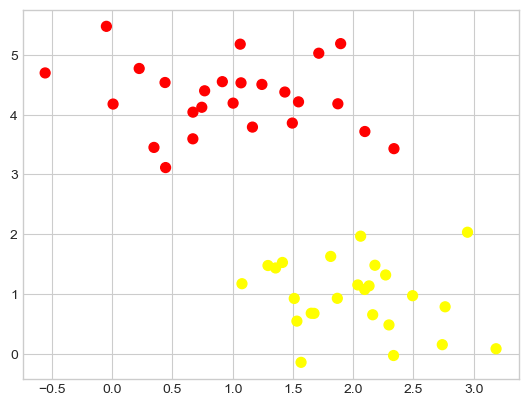

In [2]:
# Simulate two classes
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

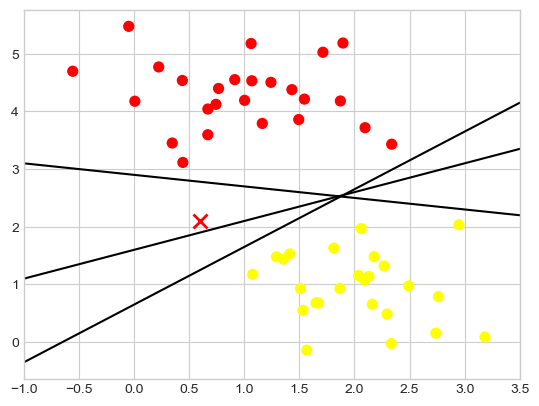

In [6]:
# Draw possible dividing lines that can perfectly discriminate between the 2 classes

x_test = np.linspace(-1, 3.5)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(x_test, m * x_test + b, '-k')

plt.xlim(-1, 3.5);

# B. Support Vector Machines: Maximizing the Margin

* Rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point.
* The line that maximizes this margin is the one we will choose as the optimal model.


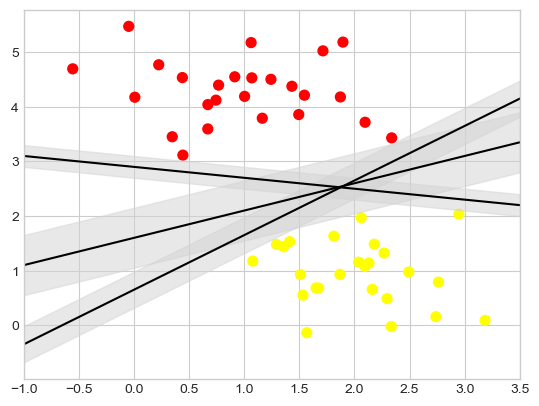

In [7]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='lightgray', alpha=0.5)
    
plt.xlim(-1, 3.5);

### B.1. Fitting a Support Vector Machine:

* A key to this classifier's succes is that for the fit, only the positions of the support vector matters; any points further from the margin that are on the correct side do not modify the fit. Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

In [8]:
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [33]:
# Create function for plotting SVM Decision Boundaries

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, 
        colors='k',
        levels=[-1, 0, 1], alpha=0.5,
        linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            s=300, linewidth=1, edgecolors='black',
            facecolors='none')
        
        for xa, ya in model.support_vectors_:
            ax.annotate('Support Vectors',
                        xy = (xa, ya),
                        xytext=(0.1, 0.8),
                        xycoords='data',
                        arrowprops=dict(arrowstyle="fancy",
                            fc="0.8", ec="none",
                            connectionstyle="angle3,angleA=5,angleB=-60")
                        )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


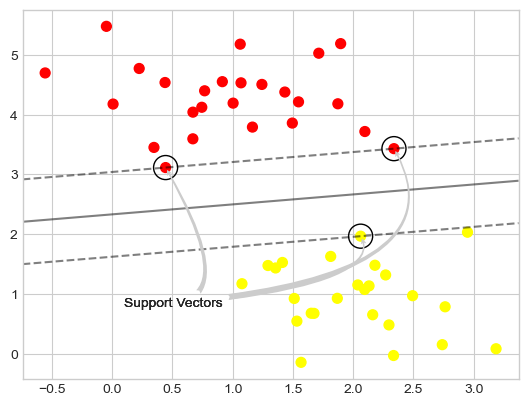

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [35]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

### B.2. Beyond Linear Boundaries: Kernel SVM

* In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF kernel, using the kernel model hyperparameter.
* This kernel transformation strategy is used often in machine learning to turn linear methods into fast nonlinear methods, especially for models in w/c the kernel trick can be used.

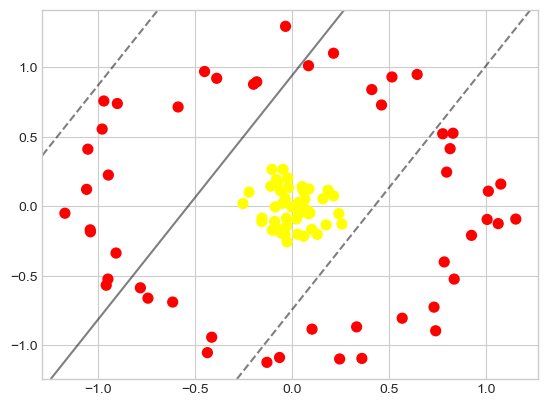

In [36]:
from sklearn.datasets import make_circles

X, y = make_circles(100, factor=.1, noise=.1)
clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

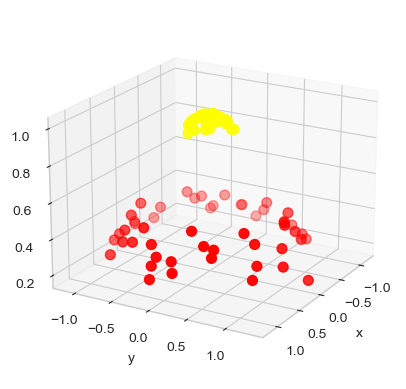

In [37]:
# Radial Basis Function
r = np.exp(-(X ** 2).sum(1))

from mpl_toolkits import mplot3d
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

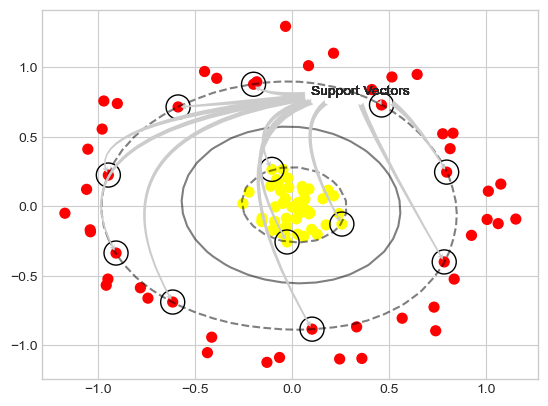

In [38]:
# Using rbf kernel in SVC

clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### B.3. Tuning the SVM: Softening Margins

* The SVM implementation has a bit of a fudge factor that “softens” the margin: 
    * That is, it allows some of the points to creep into the margin if that allows a better fit.
    * The hardness of the margin is controlled by a tuning parameter, most often known as C.
        * For a very large C, the margin is hard, and points cannot lie in it.
        * For a smaller C, the margin is softer and can grow to encompass some points.

* The optimal value of `C` will depend on your dataset, and you should tune this parameter using cross-validation or a similar procedure.

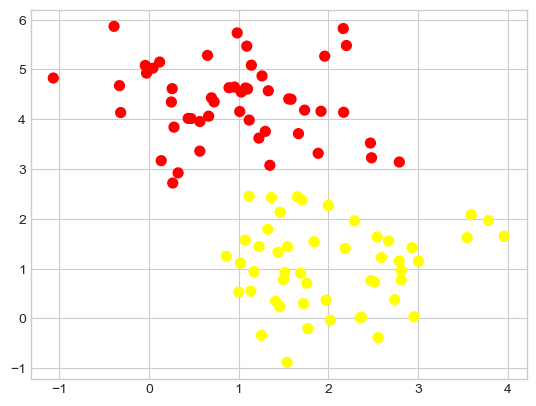

In [40]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

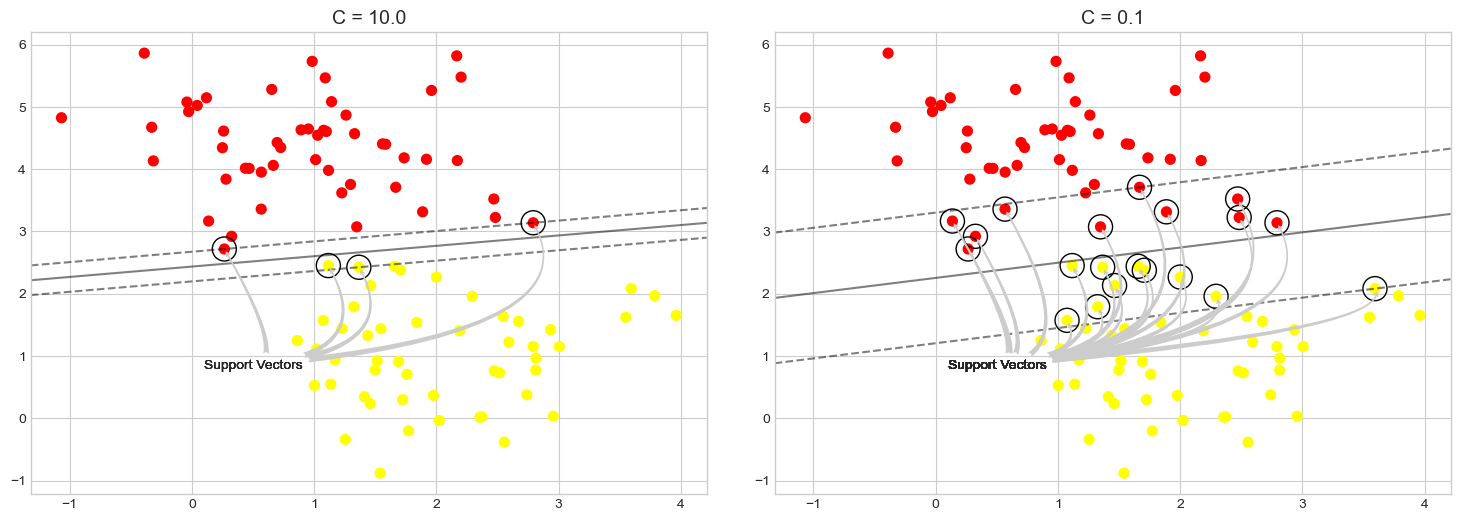

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

    plot_svc_decision_function(model, axi)
    
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

# C. Example : Face Recognition

In [42]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


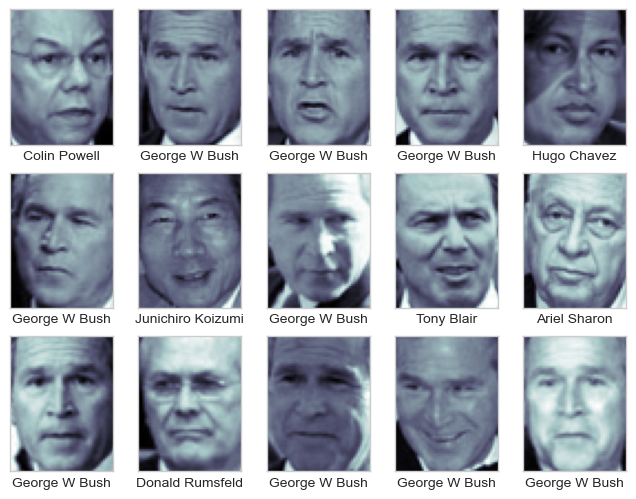

In [43]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [44]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)


pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')

model = make_pipeline(pca, svc)

param_grid = {
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 1min 24s
Wall time: 28.3 s
{'svc__C': 5, 'svc__gamma': 0.001}


In [46]:
best_model = grid.best_estimator_


In [47]:
best_model

Pipeline(steps=[('pca',
                 PCA(n_components=150, random_state=42, svd_solver='randomized',
                     whiten=True)),
                ('svc', SVC(C=5, class_weight='balanced', gamma=0.001))])

In [49]:
y_pred = best_model.predict(Xtest)

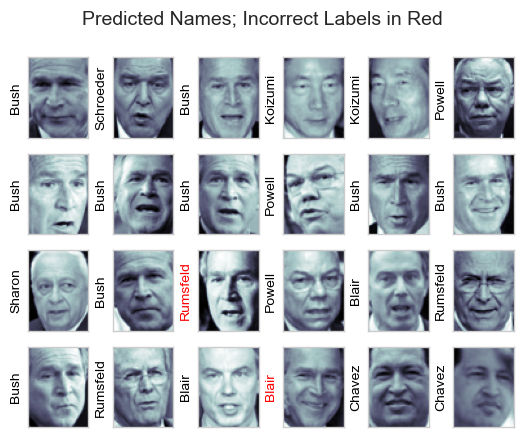

In [55]:
fig, ax = plt.subplots(4, 6)

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1], 
                    color='black' if y_pred[i] == ytest[i] else 'red')

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [56]:
from sklearn.metrics import classification_report
print(classification_report(ytest, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



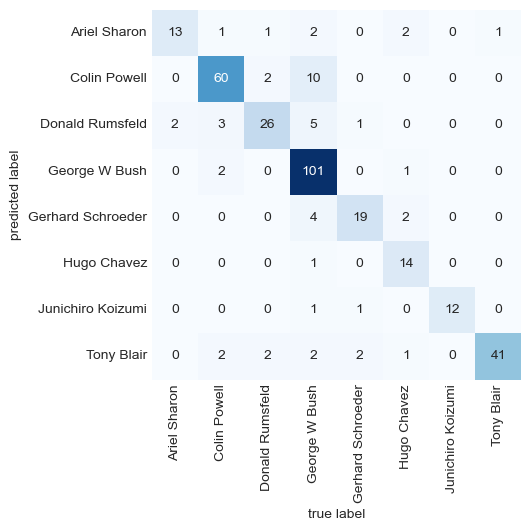

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(ytest, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

# D. SVM Advantage vs. Disadvantage:

* Several Advantages:
    * Their dependence on relatively few support vectors means that they are compact and take up very little memory.
    * Once the model is trained, the prediction phase is very fast.
    * Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is challenging for other algorithms.
    * Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

* Several Disadvantages:
    * The scaling with the number of samples N is $\mathcal{O}(N^3)$ at worst, or $\mathcal{O}(N^2)$ for efficient implementations.For large numbers of training samples, this computational cost can be prohibitive.
    * The results are strongly dependent on a suitable choice for the softening parameter C. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
    * The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the probability parameter of SVC), but this extra estimation is costly.